In [1]:
%pip install numpy pandas imageio opencv-python matplotlib seaborn scikit-learn keras tensorflow


In [2]:
!pip install kaggle

In [3]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)



Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [6]:
import os
print(os.listdir('/content'))


['.config', 'kaggle.json', 'sample_data']


In [7]:
print(os.listdir('/content'))


['.config', 'kaggle.json', 'sample_data']


In [8]:
#import necessary libraries when needed
import os
import numpy as np
import pandas as pd
import pathlib
import imageio
import cv2
import tensorflow as tf


In [10]:
# Exploring dataset
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/'
train_pneumonia_dir = base_dir+'train/PNEUMONIA/'
train_normal_dir=base_dir+'train/NORMAL/'

test_pneumonia_dir = base_dir+'test/PNEUMONIA/'
test_normal_dir = base_dir+'test/NORMAL/'

val_normal_dir= base_dir+'val/NORMAL/'
val_pnrumonia_dir= base_dir+'val/PNEUMONIA/'

train_pn = [train_pneumonia_dir+"{}".format(i) for i in os.listdir(train_pneumonia_dir) ]
train_normal = [train_normal_dir+"{}".format(i) for i in os.listdir(train_normal_dir) ]

test_normal = [test_normal_dir+"{}".format(i) for i in os.listdir(test_normal_dir)]
test_pn = [test_pneumonia_dir+"{}".format(i) for i in os.listdir(test_pneumonia_dir)]

val_pn= [val_pnrumonia_dir+"{}".format(i) for i in os.listdir(val_pnrumonia_dir) ]
val_normal= [val_normal_dir+"{}".format(i) for i in os.listdir(val_normal_dir) ]

print ("Total images:",len(train_pn+train_normal+test_normal+test_pn+val_pn+val_normal))
print ("Total pneumonia images:",len(train_pn+test_pn+val_pn))
print ("Total Normal images:",len(train_normal+test_normal+val_normal))


Total images: 5856
Total pneumonia images: 4273
Total Normal images: 1583


In [12]:
#Dataset Preprocessing & Visualization¶
#The dataset is small. So, We follow 80%, 15%, 5% split. Besides, dataset is clearly imbalanced. We will take care of it later.

# Dataset Splitting (train 80% , test 15% and validation 5% )

# Gathering all pneumina and normal chest X-ray in two python list
pn = train_pn + test_pn + val_pn
normal = train_normal + test_normal + val_normal

# Spliting dataset in train set,test set and validation set.

train_imgs = pn[:3418]+ normal[:1224]  # 80% of 4273 Pneumonia and normal chest X-ray are 3418 and 1224 respectively.
test_imgs = pn[3418:4059]+ normal[1224:1502]
val_imgs = pn[4059:] + normal[1502:]

print("Total Train Images %s containing %s pneumonia and %s normal images"
      % (len(train_imgs),len(pn[:3418]),len(normal[:1224])))
print("Total Test Images %s containing %s pneumonia and %s normal images"
      % (len(test_imgs),len(pn[3418:4059]),len(normal[1224:1502])))
print("Total validation Images %s containing %s pneumonia and %s normal images"
      % (len(val_imgs),len(pn[4059:]),len(normal[1502:])))

import random
random.seed(10) #ensure reproducability

random.shuffle(train_imgs)
random.shuffle(test_imgs)
random.shuffle(val_imgs)


Total Train Images 4642 containing 3418 pneumonia and 1224 normal images
Total Test Images 919 containing 641 pneumonia and 278 normal images
Total validation Images 295 containing 214 pneumonia and 81 normal images


In [13]:
#showing a file name from test set
print(test_imgs[5])


/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1645_virus_2845.jpeg


In [14]:
#Loading each image and their label into array

import cv2
img_size = 224

def preprocess_image(image_list):

    X = [] # images
    y = [] #labels (0 for Normal or 1 for Pneumonia)
    count=0

    for image in image_list:

        try:

            img = cv2.imread(image,cv2.IMREAD_GRAYSCALE)

            img=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_CUBIC)
            #convert image to 2D to 3D
            img = np.dstack([img, img, img])

            #convrt greyscale image to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Normalalize Image
            img = img.astype(np.float32)/255.

            count=count+1

            X.append(img)


        except:
            continue
        #get the labels
        if 'NORMAL' in image:
            y.append(0)

        elif 'IM' in image:
            y.append(0)

        elif 'virus' or 'bacteria' in image:
            y.append(1)


    return X, y


In [15]:
X, y = preprocess_image(train_imgs)


In [16]:
# Check all the images getting labels or not
arr=y
uniqueValues, occurCount = np.unique(arr, return_counts=True)

print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)


Unique Values :  [0 1]
Occurrence Count :  [1224 3418]


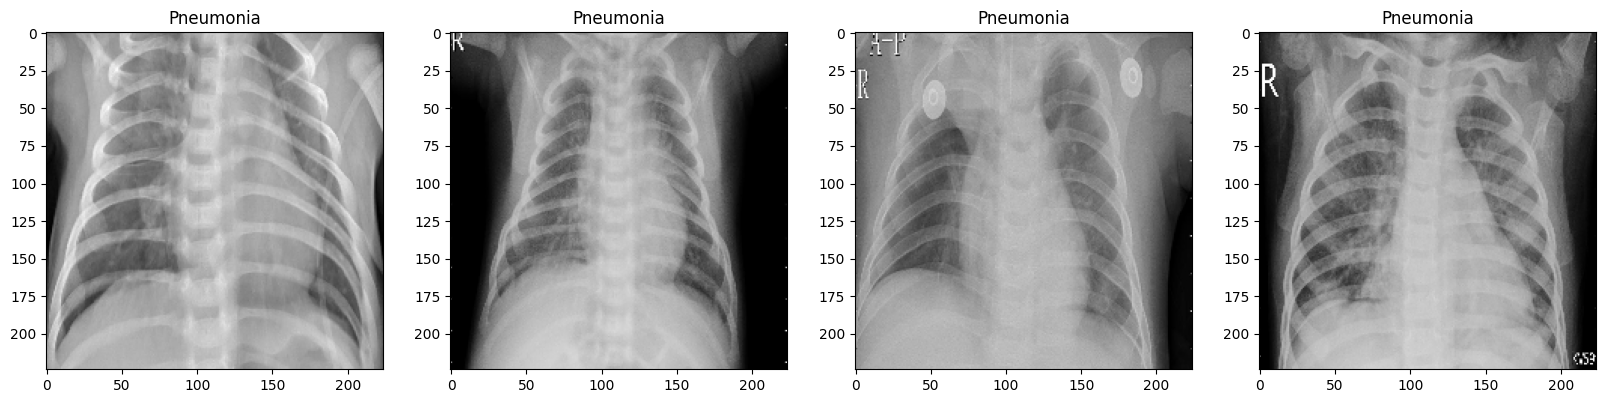

In [17]:
# Display some images from train set
# Feel free to show more image by changing the values

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    if (y[i]==0):
        a.set_title('Normal')
    else:
        a.set_title('Pneumonia')

    plt.imshow(X[i])
    k=k+1

In [18]:
# get the labels for test set

P, t = preprocess_image(test_imgs)


In [19]:
arr=t
uniqueValues, occurCount = np.unique(arr, return_counts=True)

print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)


Unique Values :  [0 1]
Occurrence Count :  [278 641]


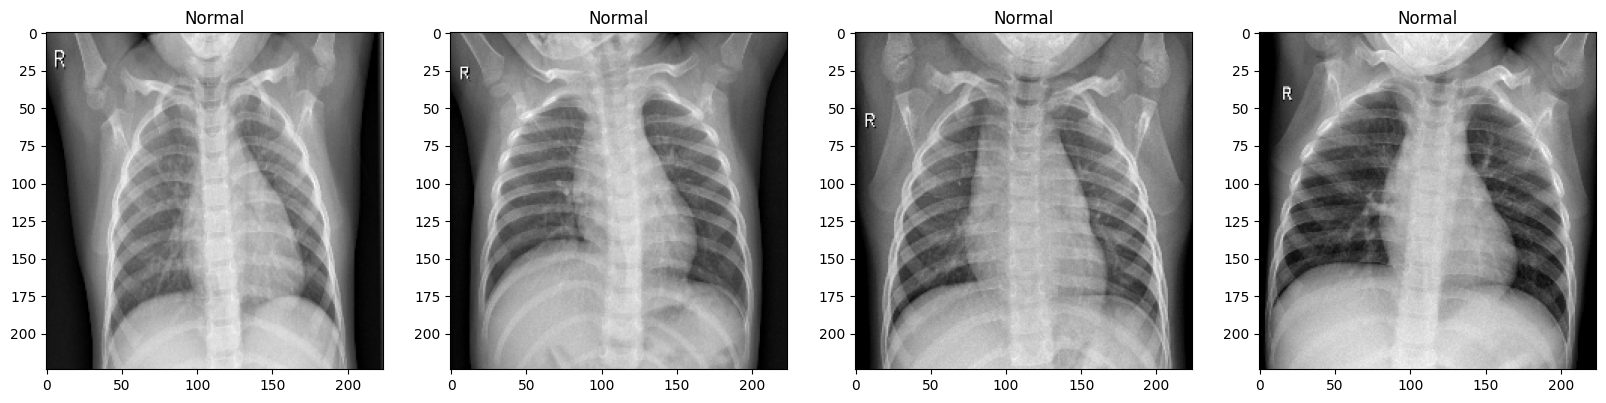

In [20]:
# now displaying some images from test set
# Feel free to show more image by changing the values

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    if (t[i]==0):
        a.set_title('Normal')
    else:
        a.set_title('Pneumonia')

    plt.imshow(P[i])
    k=k+1

In [21]:
# get the labels for validation set

K, m = preprocess_image(val_imgs)


In [22]:
arr=m


# Get a tuple of unique values & their frequency in numpy array
uniqueValues, occurCount = np.unique(arr, return_counts=True)

print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)


Unique Values :  [0 1]
Occurrence Count :  [ 81 214]


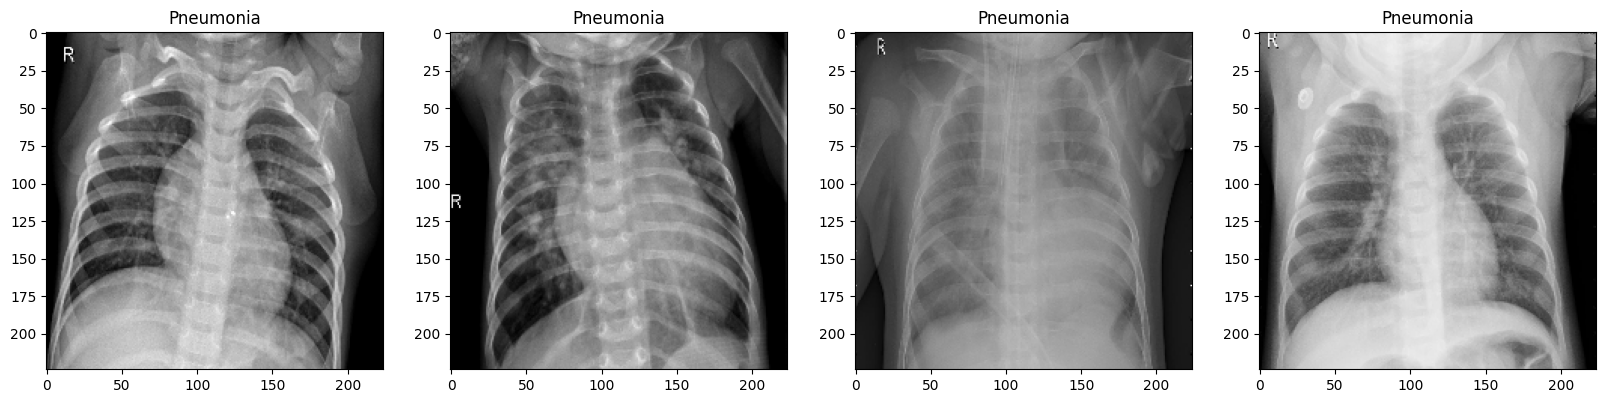

In [23]:
# now displaying some images from validation set
# Feel free to show more image by changing the values

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    if (m[i]==0):
        a.set_title('Normal')
    else:
        a.set_title('Pneumonia')

    plt.imshow(K[i])
    k=k+1

<ipython-input-24-f8bf79012cb3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, ax=ax[0], palette=['skyblue', 'orange'])
<ipython-input-24-f8bf79012cb3>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=t, ax=ax[1], palette=['skyblue', 'orange'])
<ipython-input-24-f8bf79012cb3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=m, ax=ax[2], palette=['skyblue', 'orange'])


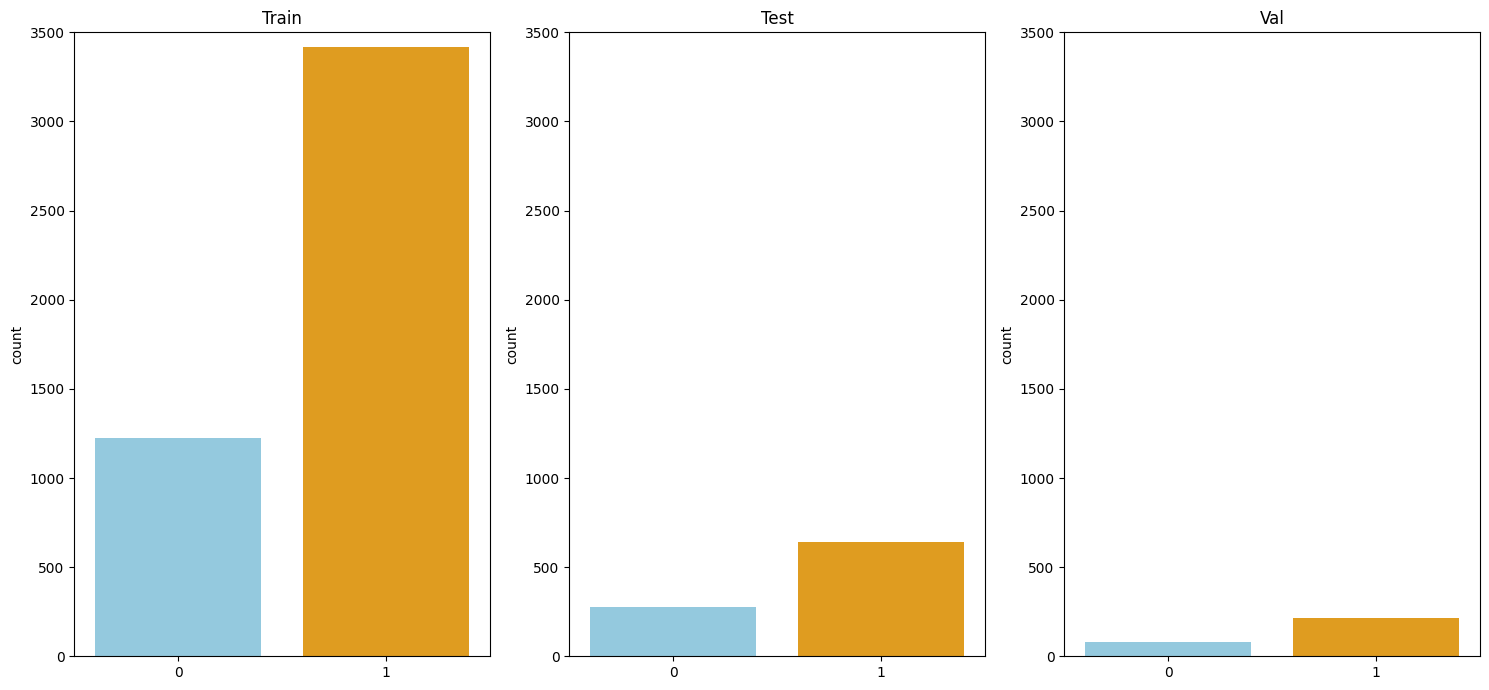

In [24]:
#Let's count and show the quantity of image in each set by counplot from Seaborn

import seaborn as sns
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

sns.countplot(x=y, ax=ax[0], palette=['skyblue', 'orange'])
ax[0].set_title('Train')
ax[0].set(ylim=(0, 3500))

sns.countplot(x=t, ax=ax[1], palette=['skyblue', 'orange'])
ax[1].set_title('Test')
ax[1].set(ylim=(0, 3500))

sns.countplot(x=m, ax=ax[2], palette=['skyblue', 'orange'])
ax[2].set_title('Val')
ax[2].set(ylim=(0, 3500))

plt.tight_layout()
plt.show()




In [25]:
#Dealing with class imbalance
#One of the simplest ways to solve the class imbalance is to simply provide a weight for each class which places more emphasis on the minority classes so CNN model can learn equally from all classes. Here, we employ sklearn compute class weight function to set weight for each class.

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),   # y = array of training labels
    y=y
)
class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: np.float64(1.8962418300653594), 1: np.float64(0.679052077238151)}


In [26]:
import gc

train_imgs = train_pn[:3875]+ train_normal[:1341]
del train_imgs
gc.collect()

X_train = np.array(X)
y_train = np.array(y)
X_test = np.array(P)
y_test = np.array(t)
X_val = np.array(K)
y_val = np.array(m)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)


(4642, 224, 224, 3)
(4642,)
(919, 224, 224, 3)
(919,)
(295, 224, 224, 3)
(295,)


In [27]:
#TRAINING
#We will use a batch size of 32. Batch size should be a power of 2 (4, 8, 16, 32, 64, 128, 256,....).
#The batch size 32 means the model will train 32 training samples and then update its parameters once. Batch training is faster and memory efficient.

# clear memory
del X
del y
gc.collect()

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

batch_size = 32


In [28]:
import tensorflow as tf
print(tf.__version__)
#Image Augmentation¶
#Lets build an input pipline for model with the augmentation technique. We artificially increase the dataset with augmentation technique, since we are using a small dataset.
# It also helps prevent overfitting.

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(  rotation_range=7,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05,
                                     shear_range=0.2,
                                     zoom_range=0.45,
                                     horizontal_flip=True)

val_datagen = ImageDataGenerator(zoom_range=0.45)



2.18.0


In [29]:
#Create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)


In [30]:
# Set image Size
img_size =224


In [31]:
#Train full train set with MobileNet¶
#We don't build a convolutional neural network (CNN) architecture from scratch here. Instead, we use a pretrainted CNN architecture called MobileNet.

from keras import layers
from keras import models
from keras import optimizers
from keras.applications import *
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from keras import backend as K

# Create the base pre-trained model
# Weights should be none becuase we don't need to train with any pre-trained weights here

base_model = MobileNet(weights=None, include_top=False,input_shape=(img_size, img_size, 3))

x = base_model.output

# Add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
# Compile model
model.compile(optimizer='adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])

In [32]:
# We can see details of  MobileNet architecure's details
#model.summary()

In [33]:
#Keep your GPU on or training time will be so high. Check your kaggle notebook's settings

# We train for 64 epochs
history = model.fit(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=64,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size,
                              class_weight =class_weights,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/64
145/145 ━━━━━━━━━━━━━━━━━━━━ 97s 467ms/step - binary_accuracy: 0.7937 - loss: 0.4634 - mae: 0.2613 - val_binary_accuracy: 0.7292 - val_loss: 0.5901 - val_mae: 0.3735
Epoch 2/64
  1/145 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step - binary_accuracy: 0.9062 - loss: 0.2361 - mae: 0.1471

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - binary_accuracy: 0.9062 - loss: 0.2361 - mae: 0.1471 - val_binary_accuracy: 0.7292 - val_loss: 0.5885 - val_mae: 0.3764
Epoch 3/64
145/145 ━━━━━━━━━━━━━━━━━━━━ 81s 558ms/step - binary_accuracy: 0.8772 - loss: 0.2840 - mae: 0.1614 - val_binary_accuracy: 0.7188 - val_loss: 0.8962 - val_mae: 0.3017
Epoch 4/64
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - binary_accuracy: 0.9062 - loss: 0.3104 - mae: 0.1445 - val_binary_accuracy: 0.7257 - val_loss: 0.8702 - val_mae: 0.2958
Epoch 5/64
145/145 ━━━━━━━━━━━━━━━━━━━━ 81s 559ms/step - binary_accuracy: 0.8857 - loss: 0.2573 - mae: 0.1521 - val_binary_accuracy: 0.7292 - val_loss: 1.4039 - val_mae: 0.2734
Epoch 6/64
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - binary_accuracy: 0.9062 - loss: 0.1983 - mae: 0.1178 - val_binary_accuracy: 0.7257 - val_loss: 1.4248 - val_mae: 0.2768
Epoch 7/64
145/145 ━━━━━━━━━━━━━━━━━━━━ 141s 581ms/step - binary_accuracy: 0.8952 - loss: 0.2424 - mae: 0.1408 - val_binary_accuracy

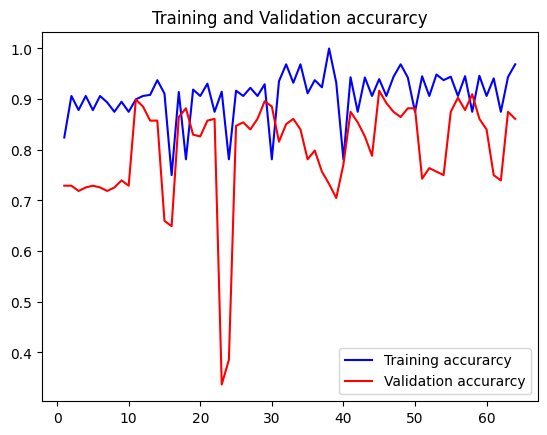

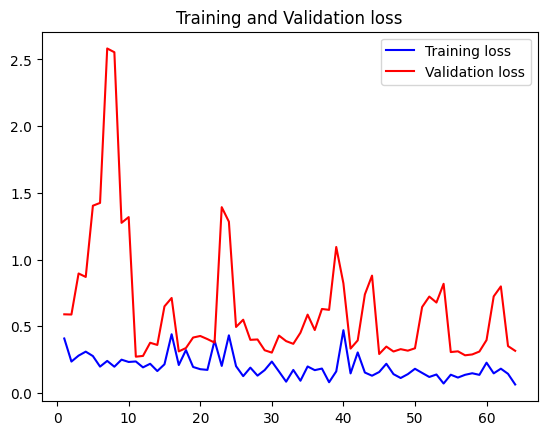

In [34]:
# Lets plot the train and val curve
# Get the details form the history object
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()


In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Predict on the test data
preds = model.predict(X_test)

# Round the predictions to 0 or 1
preds = np.round(preds)

# Calculate accuracy
acc = accuracy_score(y_test, preds) * 100

# Generate confusion matrix
cm = confusion_matrix(y_test, preds)
print('CONFUSION MATRIX ------------------')
print(cm)

# Unpack values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Compute metrics
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100   # Recall = Sensitivity
specificity = tn / (tn + fp) * 100
f1_score = 2 * (precision * recall) / (precision + recall)

# Print test metrics
print('\n============ TEST METRICS =============')
print('Accuracy: {:.2f}%'.format(acc))
print('Precision: {:.2f}%'.format(precision))
print('Recall (Sensitivity): {:.2f}%'.format(recall))
print('Specificity: {:.2f}%'.format(specificity))
print('F1-score: {:.2f}'.format(f1_score))

# Print final training accuracy
print('\n============ TRAIN METRIC =============')
print('Train Accuracy: {:.2f}%'.format(history.history['binary_accuracy'][-1] * 100))


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
CONFUSION MATRIX ------------------
[[253  25]
 [ 65 576]]

============ TEST METRICS =============
Accuracy: 90.21%
Precision: 95.84%
Recall (Sensitivity): 89.86%
Specificity: 91.01%
F1-score: 92.75

============ TRAIN METRIC =============
Train Accuracy: 96.88%


<Axes: >

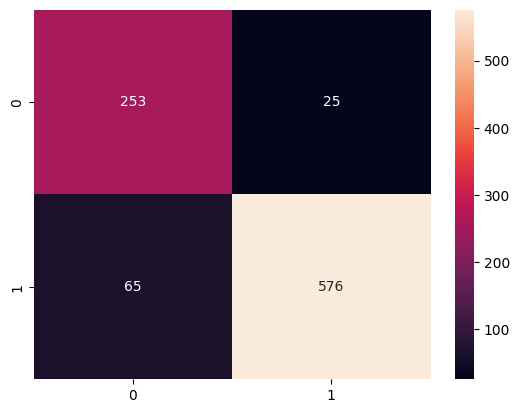

In [36]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d",)

AUC Score: 0.9769469915487268


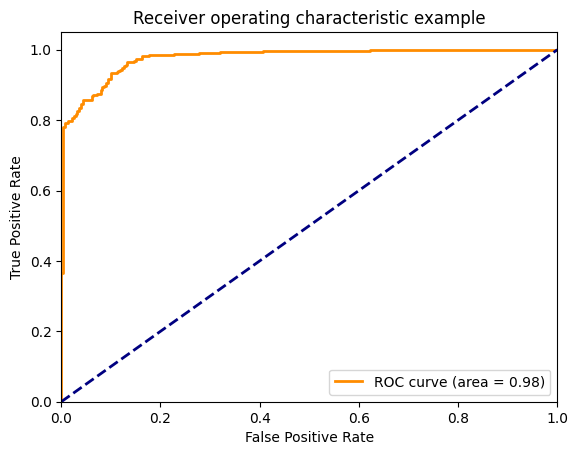

In [37]:
#The ROC (receiver operating characteristic) curve indicates the diagnostic accuracy and porformance of a model.
# We show the ROC curve and also calculate AUC score.


from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc

fpr , tpr , thresholds = roc_curve ( y_test , preds)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
